<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Компания хочет привлекать больше водителей в период пиковой нагрузки.

**Цель проекта**

Требуется построить модель для прогнозирования количество заказов такси на следующий час.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План проекта**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделайть тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor

Загрузим данные.

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col = 'datetime')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',parse_dates=[0],index_col = 'datetime')

data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Выполним ресемплирование по одному часу.

In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Вывод:**

На данном шаге были загружены данные и выполнено ресемплирование по одному часу.

## Анализ

Разложим временной ряд на тренд и сезонную компоненту.

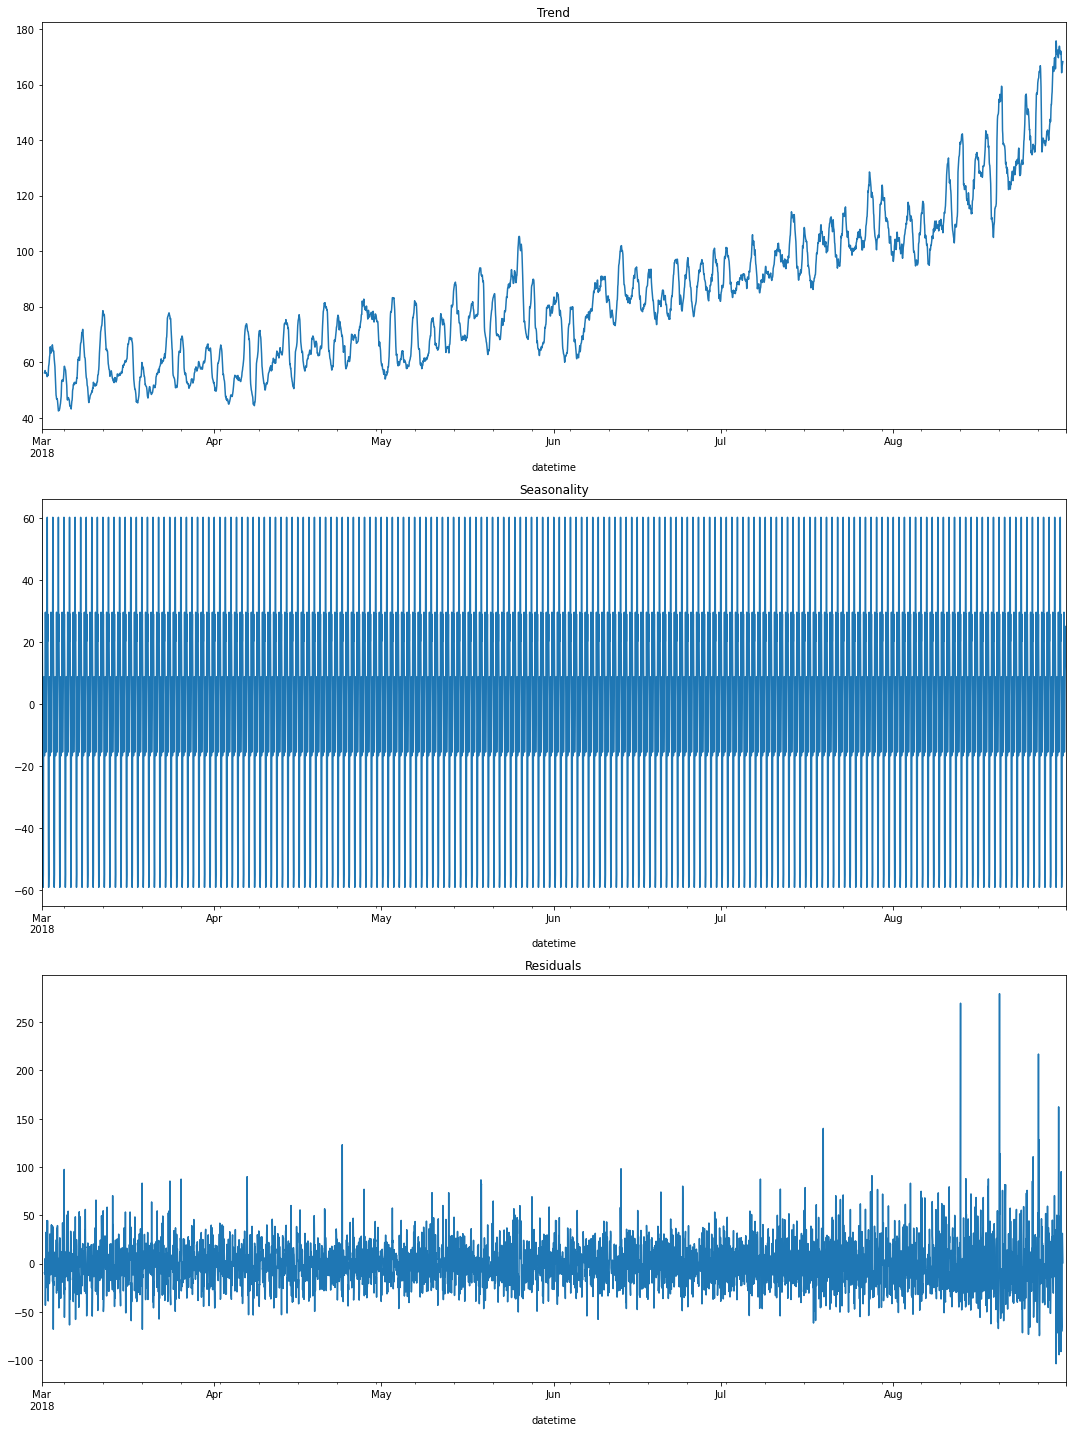

In [4]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По графику тренда видно, что на данном периоде с каждым месяцем количество поездок увеличивается. Период сезонности очень маленький. Рассмотрим последние три дня из данных.

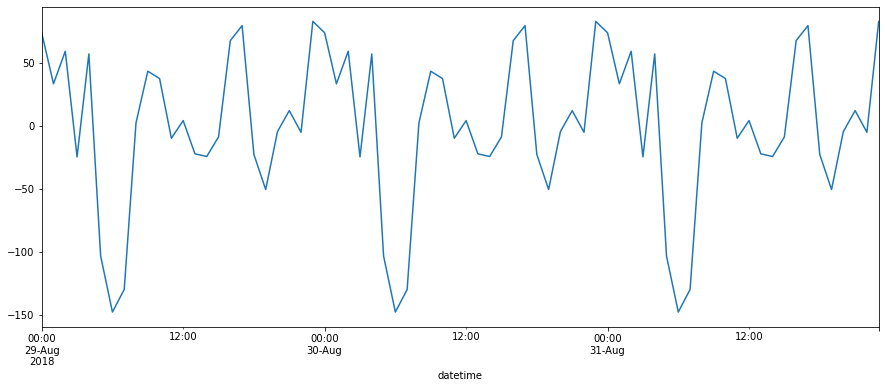

In [5]:
decomposed = seasonal_decompose(data['num_orders']['2018-08-29':'2018-08-31'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.seasonal['2018-08-29':'2018-08-31'].plot();

По графику за три последних дня видно, что есть внутрисуточная сезонность: такси пользуется спросом примерно в 09:00, 16:00 и 23:00,а меньше всего заказывают такси в 06:00.

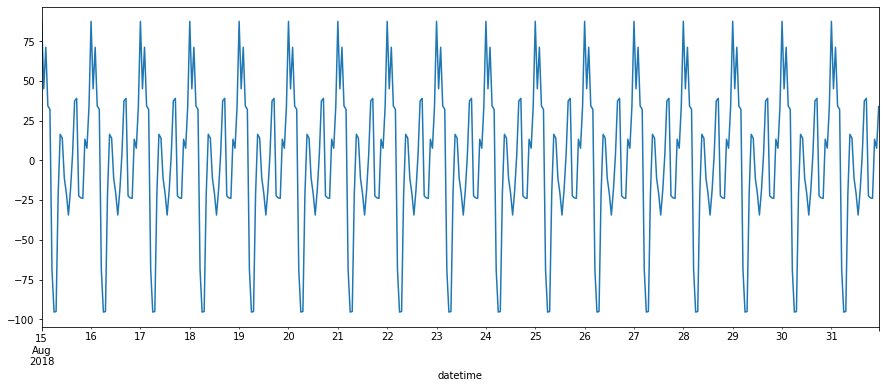

In [6]:
decomposed = seasonal_decompose(data['num_orders']['2018-08-15':'2018-08-31'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.seasonal['2018-08-15':'2018-08-31'].plot();

Дневной сезонности не наблюдается.
Так как данных у нас меньше года, то месячную сезонность вычислить нельзя.

**Вывод:**

Временной ряд был разложен на тренд и сезонную компоненту. По графику тренда видно, что на данном периоде с каждым месяцем количество поездок увеличивается. По графику за три последних дня видно, что есть внутрисуточная сезонность: такси пользуется спросом примерно в 09:00, 16:00 и 23:00,а меньше всего заказывают такси в 06:00. Дневной сезонности не наблюдается.
Так как данных у нас меньше года, то месячную сезонность вычислить нельзя.

## Обучение

Добавим признаки для прогнозирования.

In [7]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

Определим наилучшие параметры максимального размера отставания и ширины окна для скользящего среднего.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

'''best_i = 0
best_j = 0
best_rmse = 1000



for i in range(1,30):
    for j in range(1,30):
        data = data[['num_orders','hour','dayofweek']]
        
        make_features(data, i, j)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        features_train = train.drop(['num_orders'], axis = 1)
        features_valid = test.drop(['num_orders'], axis = 1)
        target_train = train['num_orders']
        target_valid = test['num_orders']

        model = LGBMRegressor(random_state=12345)
        model.fit(features_train,target_train)
        pred_train = model.predict(features_train)
        pred_valid = model.predict(features_valid)
        rmse =  mean_squared_error(target_valid,pred_valid)**0.5
        
        if(rmse < best_rmse):
            best_rmse = rmse
            best_i = i
            best_j = j
print('Наилучшие параметры:')
print('Максимальный размер отставания:',best_i)
print('Ширина окна для скользящего среднего:',best_j)
'''

Выставим следующие гиперпараметры: лаг равное 1, а скользящее среднее равное 24 (среднее за сутки). Разобьем данные на обучающую и тестовую выборку в соотношении 90/10.

In [9]:
data = data[['num_orders','hour','dayofweek']]
make_features(data, 1, 24)
train, test = train_test_split(data.copy(), shuffle=False, test_size=0.1)
train = train.dropna()

In [10]:
features_train = train.drop(['num_orders'], axis = 1)
features_test = test.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']

Построим модель с использованием алгоритма дерева решений.

Аргументу n_split для функции TimeSeriesSplit присвоим значение равное количеству месяцев в данных 6.

In [11]:
tscv = TimeSeriesSplit(n_splits=6)

In [12]:
model = DecisionTreeRegressor()
params = {'max_depth':np.arange(1,11)}
search_DecisionTreeRegressor = GridSearchCV(estimator = model, scoring='neg_root_mean_squared_error', param_grid = params, cv=tscv)
search_DecisionTreeRegressor.fit(features_train,target_train)
print(search_DecisionTreeRegressor.best_estimator_)
print(search_DecisionTreeRegressor.best_score_)

DecisionTreeRegressor(max_depth=7)
-28.935741070919544


Построим модель с использованием алгоритма случайного леса.

In [13]:
model = RandomForestRegressor()
params = {'max_depth':np.arange(1,7),
         'n_estimators':np.arange(20, 50, 10)}
search_RandomForestRegressor = RandomizedSearchCV(estimator = model, scoring='neg_root_mean_squared_error', param_distributions = params, cv=tscv)
search_RandomForestRegressor.fit(features_train,target_train)
print(search_RandomForestRegressor.best_estimator_)
print(search_RandomForestRegressor.best_score_)

RandomForestRegressor(max_depth=6, n_estimators=30)
-27.254327419104545


Построим модель с использованием линейной регрессии и кросс-валидации.

In [14]:
LinearRegression_model = LinearRegression()
LinearRegression_best_score_ = cross_val_score(LinearRegression_model,features_train, target_train, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()
print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', LinearRegression_best_score_)

Значение метрики RMSE на обучающей выборке для LinearRegression -31.554523970745354


In [15]:
model = LGBMRegressor()
params = {'max_depth':np.arange(1,11),
         'n_estimators':np.arange(20, 80, 10)}
search_LGBMRegressor = GridSearchCV(estimator = model, scoring='neg_root_mean_squared_error', param_grid = params, cv=tscv)
search_LGBMRegressor.fit(features_train,target_train)
print(search_LGBMRegressor.best_estimator_)
print(search_LGBMRegressor.best_score_)

LGBMRegressor(max_depth=7, n_estimators=60)
-25.07917285317569


Сравним все модели

In [16]:
pd.DataFrame({'Модель':[search_DecisionTreeRegressor.best_estimator_, search_RandomForestRegressor.best_estimator_, LinearRegression_model, search_LGBMRegressor.best_estimator_],'best_score_':[search_DecisionTreeRegressor.best_score_, search_RandomForestRegressor.best_score_, LinearRegression_best_score_,search_LGBMRegressor.best_score_]}) 

,Модель,best_score_
0,DecisionTreeRegressor(max_depth=7),-28.935741
1,"(DecisionTreeRegressor(max_depth=6, max_featur...",-27.254327
2,LinearRegression(),-31.554524
3,"LGBMRegressor(max_depth=7, n_estimators=60)",-25.079173


Наилучший результат показала модель LGBMRegressor(max_depth=7, n_estimators=60).

**Вывод:**

1. Были добавлены признаки для прогнозирования.
2. Определены наилучшие параметры максимального размера отставания и ширины окна для скользящего среднего.
3. Данные были разбиты на обучающую и тестовую выборку в соотношении 90/10.
4. Были проанализированы модели с использованием алгоритма дерева решений, с использованием алгоритма случайного леса, линейной регрессии и с использованием бустинга. Наилучший результат rmse показала модель LGBMRegressor(max_depth=7, n_estimators=60).

## Тестирование

Протестируем модель LGBMRegressor(max_depth=7, n_estimators=60).

In [17]:
model = LGBMRegressor(max_depth=7, n_estimators=60)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

mean_squared_error(target_test, predictions) ** 0.5

43.53706187493086

Построим график за три дня фактических и предсказанных данных.

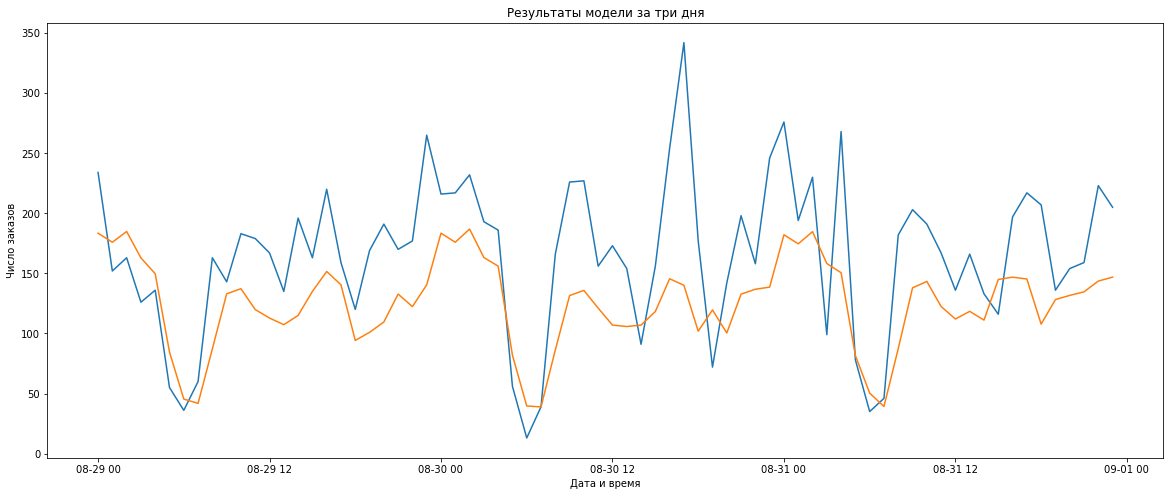

In [18]:
plt.figure(figsize=(20, 8))
plt.title('Результаты модели за три дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.plot(target_test['2018-08-29':'2018-08-31']);
plt.plot(pd.DataFrame(predictions, index = target_test.index)['2018-08-29':'2018-08-31']);
plt.show()

Модель показала себя хорошо, значение метрики RMSE на тестовой выборке меньше 48, соответственно, модель успешно прошла тестирование.

**Вывод:**

Модель успешно прошла тестирование, так как значение метрики RMSE на тестовой выборке меньше 48.

## Общий вывод

1. Подготовка

    На первом шаге были загружены данные и выполнено ресемплирование по одному часу.


2. Анализ

    Временной ряд был разложен на тренд и сезонную компоненту. По графику тренда видно, что на данном периоде с каждым месяцем количество поездок увеличивается. По графику за три последних дня видно, что есть внутрисуточная сезонность: такси пользуется спросом примерно в 09:00, 16:00 и 23:00,а меньше всего заказывают такси в 06:00. Дневной сезонности не наблюдается.
    Так как данных у нас меньше года, то месячную сезонность вычислить нельзя.


3. Обучение

    3.1. Были добавлены признаки для прогнозирования.
    
    3.2. Определены наилучшие параметры максимального размера отставания и ширины окна для скользящего среднего.
    
    3.3. Данные были разбиты на обучающую и тестовую выборку в соотношении 90/10.
    
    3.4. Были проанализированы модели с использованием алгоритма дерева решений, с использованием алгоритма случайного леса, линейной регрессии и с использованием бустинга. Наилучший результат rmse показала модель LGBMRegressor(max_depth=7, n_estimators=60).
    

4. Тестирование
    
    Был построен график за три дня фактических и предсказанных данных.
    Модель показала себя хорошо, значение метрики RMSE на тестовой выборке меньше 48, соответственно, модель успешно прошла тестирование.